In [10]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.signal
import os
from joblib import dump, load

from IPython.display import Audio
from matplotlib_inline.backend_inline import set_matplotlib_formats
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

set_matplotlib_formats("svg")

In [3]:
# le traitement se fait au niveau de chaque fichier
# label sera défini avant
def load_audio(filepath = './sounds/'):
    # load_audio parcourt chacun des fichiers
    y_voice, sr_voice = librosa.load(filepath)
    return y_voice, sr_voice

In [4]:
def noise_sup(y_voice, sr, order=2,lf=0.0128,hf=0.05):
    b, a = scipy.signal.butter(order, [lf,hf], btype='bandpass', fs=sr)
    # ça marche pas trop mal avec aussi avec 0.0128, 0.05
    # apply the filter using `scipy.signal.lfilter`
    y_voice_filt = scipy.signal.lfilter(b, a, y_voice)
    
    return y_voice_filt

In [5]:
# frame length de 2048 doit marcher
# top_db fine tuned à 45 semble bien marcher
def silence_sup(y_voice,fl=2048,tdb=45):
    voice_intervals = librosa.effects.split(y_voice, top_db = tdb ,frame_length=fl)
    sound_intervals =[y_voice[voice_intervals[i][0]:voice_intervals[i][1]] for i in range(0,len(voice_intervals))]
    silenceless_voice = np.concatenate(sound_intervals)
    return silenceless_voice

In [6]:
# generate dataset from the audio signal, the samplerate and the label
# n_mels = 128 nombre de fenêtre choisit sur lesquels ont fait les moyennes pour obtenir une amplitude
def generate_dataset(silenceless_voice, sr, label, nm = 128):
    # generate Mel spectrogram
    spec = librosa.feature.melspectrogram(y=silenceless_voice, sr=sr, n_mels=nm)
    # generate DataFrame from spectrogram (columns: frequencies, rows: analysis frames)
    X = pd.DataFrame(spec.T)
    # generate Series for the labels (same label for all examples)
    y = pd.Series(label).repeat(len(X))
    return X, y

* scaling avec du log ?

In [7]:
# default parameters

#frame_length = 2048

def data_pipeline(folder_path = './sounds/',label_list= ['cinthya','gabriel','autre']):
    X_full = pd.DataFrame()
    y_full = pd.Series()
    
    for elt in label_list:
        complete_path =  folder_path + elt
        file_list = os.listdir('./sounds/'+elt)

        for f_elt in file_list:

            file_path = complete_path +'/' +f_elt
            audio, sr = load_audio(file_path)
            #noise = noise_sup(audio,sr)
            silence = silence_sup(audio)
            X, y = generate_dataset(silence, sr, elt)
            #X, y = generate_dataset(
            #    silence_sup(
            #        noise_sup(
            #            load_audio(file_path)[0],load_audio(file_path)[1]
            #        )
            #    )
            #,elt)
            X_full = pd.concat([X_full,X],ignore_index=True) 
            y_full = pd.concat([y_full,y],ignore_index=True)
    df=pd.concat([X_full,y_full.reindex(X_full.index)],axis=1,ignore_index=True)
    return df

In [13]:
def analyse(register):
    pipe= load('./models.joblib')
    audio, sr = librosa.load(register)
    silence = silence_sup(audio)
    X,_= generate_dataset(silence, sr,'?')
    pred=pipe.predict(X)
    labels, counts = np.unique(pred, return_counts=True)
    resultat=labels[np.argmax(counts)]
    
    return resultat

In [14]:
analyse('./sounds/autre')

'cinthya'

In [45]:
df=data_pipeline('./sounds/',['autre','cinthya','gabriel',])

/tmp/ipykernel_14281/238982183.py:7: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  y_full = pd.Series()


In [46]:
def ml_preprocessing(df):
    
    grade_list=['gabriel','cinthya','autre']
    min_size = min([len(df[df[128] == grade]) for grade in grade_list])

    # équilibrage des classes
    frames = [df[df[128] == grade].sample(min_size) for grade in grade_list]

    # nouveau dataframe
    down_samp = pd.concat(frames)

    return(down_samp)

In [47]:
df=ml_preprocessing(df)

In [72]:
X=df.drop(128,axis=1)
y=df.iloc[:,-1:]
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.33, random_state=42)
pipe = Pipeline([('scaler', StandardScaler()),
                 ('clf', RandomForestClassifier(max_depth= 10, n_estimators= 200, random_state=0))
])
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
print(accuracy_score(y_test, y_pred))
print(f1_score(y_test, y_pred, pos_label=pipe.classes_[1], average="macro"))


/home/ferrand/.local/share/virtualenvs/qui-est-ce-feat-gabriel-tvi9UEDJ/lib/python3.8/site-packages/sklearn/pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


0.9341032608695652
0.9360301906372043


/home/ferrand/.local/share/virtualenvs/qui-est-ce-feat-gabriel-tvi9UEDJ/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1386: UserWarning: Note that pos_label (set to 'cinthya') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


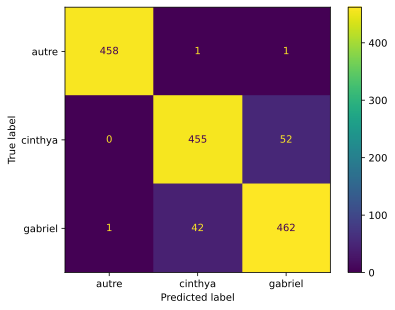

In [73]:
_ = ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

In [76]:
dump(pipe,'models.joblib')

['models.joblib']

In [210]:
avec silence : 0.7989130434782609
0.7973363377938013

sans silence : 0.7921195652173914
0.7908378843379218

In [1]:
parameters = {'max_depth':[2,5,8,10],'n_estimators':[50,100,200,300] }
svc = RandomForestClassifier(random_state=0)
clf = GridSearchCV(svc, parameters)
clf.fit(X_train, y_train.to_numpy().ravel())


NameError: name 'RandomForestClassifier' is not defined

In [62]:
y_train.to_numpy().ravel()

array(['gabriel', 'cinthya', 'autre', ..., 'autre', 'autre', 'gabriel'],
      dtype=object)

In [69]:
print(clf.best_params_, clf.best_score_)


{'max_depth': 10, 'n_estimators': 200} 0.9403914780143753


k-nn = {'n_neighbors': 5, 'p': 1} 0.7917043411035108
rdf = {'max_depth': 10, 'n_estimators': 200}

In [103]:
analyse('./sounds/cinthya/lowcin')



'cinthya'

In [90]:
test

0
0      -0.000397
1      -0.000763
2      -0.001160
3      -0.001526
4      -0.001740
...          ...
288763  0.000000
288764  0.000000
288765  0.000000
288766  0.000000
288767  0.000000

[288768 rows x 1 columns]

In [15]:
librosa.load('output.wav')

(array([-0.3476901 , -0.5223842 , -0.45777532, ..., -0.00775819,
        -0.00680661, -0.00748014], dtype=float32),
 22050)